# Fake news detection with traditional approach

This notebook presents ML models for predicting if a news text is fake or not using traditional ML techniques such as clustering, ensamble methods or bayes.

## Load data

In [56]:
import pandas as pd
from transformers import AutoModel, BertTokenizerFast, TFBertModel, AutoTokenizer, BertTokenizer
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
url='https://drive.google.com/file/d/1cT8q8-rU-5T7TEKAB5oGkIAhS6dOD3O9/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_csv(url, delimiter=';')
data.head()

,site,retweetCount,quoteCount,likeCount,replyCount,rawContent,retweetedTweet,quotedTweet,real
0,eltiempo,13,0,23,1,☀️¡Buenos días! Amanecemos con las noticias má...,False,False,1
1,eltiempo,0,0,1,0,#Deportes | Dayro Moreno: el insólito regalo q...,False,False,1
2,eltiempo,0,0,5,2,"Néstor Lorenzo, el técnico de la Selección, ah...",False,False,1
3,eltiempo,2,0,4,1,"🔴#EnVivo | Diego Torres, representante de los ...",False,False,1
4,eltiempo,1,0,0,0,🔴 Bienvenido a #CityNoticiasMD. Conéctese para...,False,False,1


## Data analysis

### Dictionary

Dataset contains the following fields

- site: Twitter account that tweeted the news, we divided this in two categories, official and recognized new sites (e.g. @eltiempo, @noticiascaracol) and twitter accounts that are recognized for publishing fake news as a satire (e.g. @actualidadpanam, @ChiguireBipolar)
- retweetCount: How many retweets does the tweet have.
- quoteCount: How many quotes does the tweet have.
- likeCount: How many likes does the tweet have.
- replyCount: How many replies does the tweet have.
- rawContent: The raw text of the tweet.
- retweetedTweet: True if the tweet is a retweet, this means that the user did not publish the news but instead retweet it from another site. False if is not a retweet tweet.
- quotedTweet: True if the tweet is a quote, this means that the user did not publish the news but instead quoted it from another site. False if is not a quote from another tweet.
- real: Label that means if the news is fake or not. True if is a real news, False if considered fake.


### Profiling

We start profiling our data in order to analyze their structure.

In [3]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the profiling we found the following insights:

- There are 0.7% duplicate rows which means the dataset contains repeated tweets, we should eliminate this data.
- There is no missing data.
- Site is highly correlated with the label (real), this is expected since all official news sites tweets were considered as real and satire site news were all considered as fake. This is only a informatory field and we should remove it.
- retweetCount, quoteCount, likeCount, replyCount has multiple zeroes and are highly skewed since some accounts may be more famous than others and also some tweets may have been more popular than others. We should not consider this fields considering also that they have high correlation between them.
- retweetedCount and quotedTweed are highly imbalanced this means that the majority of tweets were fully written by the author, we should remove the retweeted and quoted ones cause we do not have information if the account that did the original tweet is realiable or not in order to consider the tweet as fake or real.
- real is balanced so we have almost the same amount for fake and real tweets which is ideal.

## Data transformations

We are going to apply required transformations in order for the algorithms to interpret the text and also we want to remove fields and data entries that were found as not necessary after executing the profiling.

In [4]:
data = data[data['retweetedTweet'] != True]
data = data[data['quotedTweet'] != True]
data = data.drop(columns=[
  'retweetCount', 'quoteCount', 'likeCount', 'replyCount', 'site', 'retweetedTweet', 'quotedTweet'
])
data = data.drop_duplicates()

In [5]:
data.head()

,rawContent,real
0,☀️¡Buenos días! Amanecemos con las noticias má...,1
1,#Deportes | Dayro Moreno: el insólito regalo q...,1
2,"Néstor Lorenzo, el técnico de la Selección, ah...",1
3,"🔴#EnVivo | Diego Torres, representante de los ...",1
4,🔴 Bienvenido a #CityNoticiasMD. Conéctese para...,1


In [6]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split data

In [6]:
df_X = data['rawContent'] 
df_y = data['real']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=2024, test_size=0.2)

## Split and tokenize data

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
example_text = [data.iloc[0]['rawContent']]
tokenizer.batch_encode_plus(example_text, padding=True, return_token_type_ids=False)

{'input_ids': [[101, 100, 1067, 9204, 22939, 2015, 999, 25933, 2638, 3401, 15530, 9530, 5869, 2025, 24108, 2015, 16137, 2590, 2229, 1061, 5025, 21335, 8883, 3972, 22939, 1012, 100, 2158, 6528, 12617, 2063, 12367, 9365, 1037, 15549, 1012, 100, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 23969, 2497, 2595, 12190, 4160, 22895, 2546, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 5641, 2121, 2509, 26212, 2278, 2290, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

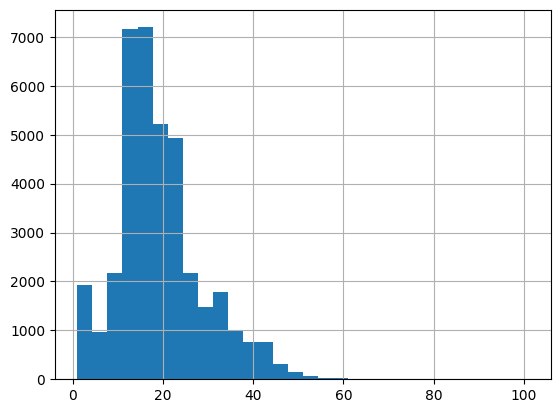

In [10]:
seq_len = [len(i.split()) for i in data['rawContent']]
pd.Series(seq_len).hist(bins=30)
plt.show()

In [11]:
max_seq_len = 20

In [12]:
def tokenize(text_data):
    return tokenizer(
        text = list(text_data),
        add_special_tokens = True,
        max_length = max_seq_len,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
    )
    

In [13]:
X_train_tokenize = tokenize(X_train)
X_test_tokenize = tokenize(X_test)

## Build model

In [14]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
def create_model():
    dropout_rate = 0.2
    input_ids = Input(shape=(max_seq_len,), dtype=tf.int32)
    input_mask = Input(shape=(max_seq_len,), dtype=tf.int32)
    
    bert_layer=bert_model([input_ids,input_mask])[1]
    
    x = Dropout(0.5)(bert_layer)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [25]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 20, 76                                           
                             8),                                                              

In [33]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)


In [34]:
callback = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

## Train model

In [66]:
first_input_key = 'input_5'
second_input_key = 'input_6'

In [51]:
history = model.fit(
    x={f'{first_input_key}': X_train_tokenize['input_ids'], f'{second_input_key}': X_train_tokenize['attention_mask']},
    y=y_train,
    epochs=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[callback]
)


191/191 [==============================] - 1183s 6s/step - loss: 0.7431 - accuracy: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.5133


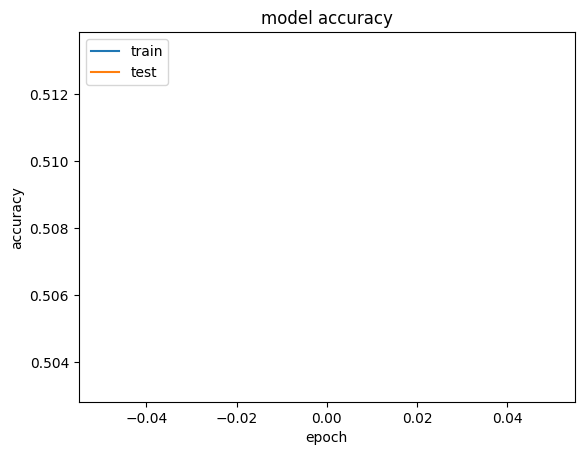

In [52]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

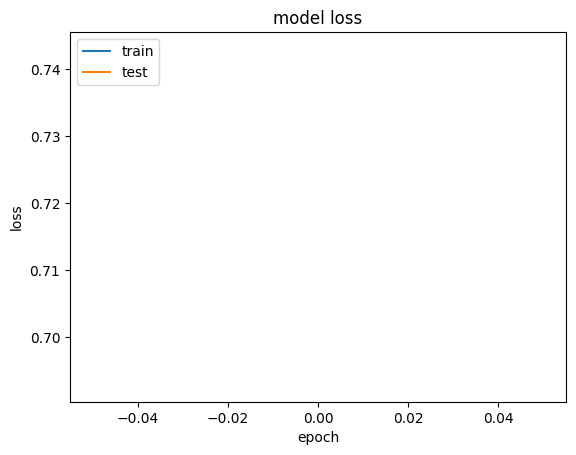

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Validate test

In [57]:
y_pred = np.where(
    model.predict({ f'{first_input_key}' : X_test_tokenize['input_ids'] , f'{second_input_key}' : X_test_tokenize['attention_mask']}) >=0.5,1,0
)

239/239 [==============================] - 111s 462ms/step


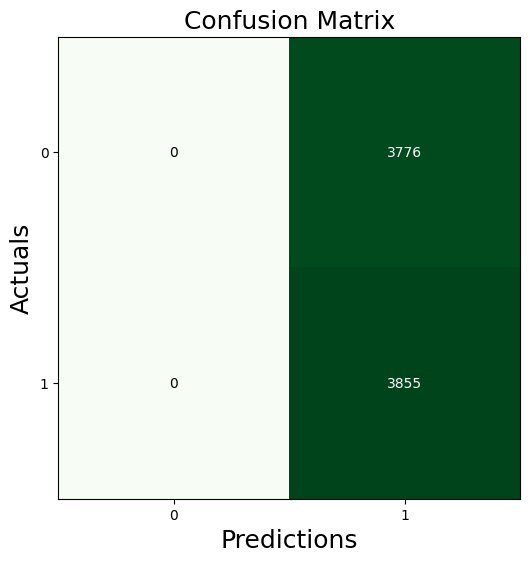

In [58]:
conf_matrix = confusion_matrix(y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Predict new data

In [59]:
new_test_text = "Barcelona gana la champions league 2024"

In [60]:
new_test_text_tokenize = tokenize(new_test_text)

In [67]:
test_text_pred = np.where(
    model.predict({ f'{first_input_key}' : new_test_text_tokenize['input_ids'] , f'{second_input_key}' : new_test_text_tokenize['attention_mask']}) >=0.5,1,0
)

2/2 [==============================] - 1s 197ms/step


In [64]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")

News is Real
